In [ ]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# installing tensorflow-gpu
!pip install tensorflow-gpu

In [ ]:
# general imports
import tensorflow as tf
import os
import glob
import pandas as pd
import io
import xml.etree.ElementTree as ET
import argparse
import cv2
import csv
from PIL import Image
from collections import namedtuple

# checking availability of GPU
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

#checking tensorflow version
print(tf.__version__)

Default GPU Device: /device:GPU:0
2.12.0


In [ ]:
# cloning tensorflow models repository
%cd /content/drive/MyDrive/tensorflow_custom_object_detection
!git clone https://github.com/tensorflow/models.git

/content/drive/MyDrive/tensorflow_custom_object_detection
Cloning into 'models'...
remote: Enumerating objects: 85344, done.
remote: Counting objects: 100% (972/972), done.
remote: Compressing objects: 100% (447/447), done.
remote: Total 85344 (delta 588), reused 890 (delta 520), pack-reused 84372
Receiving objects: 100% (85344/85344), 598.52 MiB | 15.05 MiB/s, done.
Resolving deltas: 100% (61077/61077), done.
Updating files: 100% (3474/3474), done.


In [ ]:
# compiling protobuf
%cd /content/drive/MyDrive/tensorflow_custom_object_detection/models/research
!protoc object_detection/protos/*.proto --python_out=.

/content/drive/MyDrive/tensorflow_custom_object_detection/models/research


In [ ]:
# installing COCO API
!git clone https://github.com/cocodataset/cocoapi.git
%cd cocoapi/PythonAPI
!make

In [ ]:
# installing object detection API
%cp -r pycocotools /content/drive/MyDrive/tensorflow_custom_object_detection/models/research
%cd ..
%cd ..
%cp object_detection/packages/tf2/setup.py .
!python -m pip install .

In [ ]:
# testing model builder
!python object_detection/builders/model_builder_tf2_test.py

In [ ]:
# getting data
%cd /content/drive/MyDrive/tensorflow_custom_object_detection

!wget https://sci2s.ugr.es/sites/default/files/files/TematicWebSites/WeaponsDetection/BasesDeDatos/WeaponS.zip
!unzip -q WeaponS.zip

!wget https://sci2s.ugr.es/sites/default/files/files/TematicWebSites/WeaponsDetection/BasesDeDatos/WeaponS_bbox.zip
!unzip -q WeaponS_bbox.zip

/content/drive/MyDrive/tensorflow_custom_object_detection
--2023-05-03 10:35:56--  https://sci2s.ugr.es/sites/default/files/files/TematicWebSites/WeaponsDetection/BasesDeDatos/WeaponS.zip
Resolving sci2s.ugr.es (sci2s.ugr.es)... 150.214.190.154
Connecting to sci2s.ugr.es (sci2s.ugr.es)|150.214.190.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250005059 (238M) [application/zip]
Saving to: ‘WeaponS.zip’

WeaponS.zip         100%[===================>] 238.42M  11.1MB/s    in 22s     

2023-05-03 10:36:18 (10.8 MB/s) - ‘WeaponS.zip’ saved [250005059/250005059]

--2023-05-03 10:36:44--  https://sci2s.ugr.es/sites/default/files/files/TematicWebSites/WeaponsDetection/BasesDeDatos/WeaponS_bbox.zip
Resolving sci2s.ugr.es (sci2s.ugr.es)... 150.214.190.154
Connecting to sci2s.ugr.es (sci2s.ugr.es)|150.214.190.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1420022 (1.4M) [application/zip]
Saving to: ‘WeaponS_bbox.zip’

WeaponS_bbox.zip

In [ ]:
# storing data into a directory
!mkdir data

# creating folders for test and train data
!mkdir data/images data/train_labels data/test_labels

# combining images and annotations
!mv WeaponS/* data/images
!mv WeaponS_bbox/* data/train_labels

# removing zip files
!rm -rf WeaponS_bbox.zip  WeaponS.zip WeaponS/  WeaponS_bbox/

In [ ]:
# sorting and adding data to test and train folders
!ls data/train_labels/* | sort -R | head -600 | xargs -I{} mv {} data/test_labels

In [ ]:
# converting all files from xml to csv and generating label_map.pbtxt

%cd /content/drive/MyDrive/tensorflow_custom_object_detection/data

# images extension
images_extension = 'jpg'

def xml_to_csv(path):
  classes_names = []
  xml_list = []

  for xml_file in glob.glob(path + '/*.xml'):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for member in root.findall('object'):
      classes_names.append(member[0].text)
      value = (root.find('filename').text + '.' + images_extension,
               int(root.find('size')[0].text),
               int(root.find('size')[1].text),
               member[0].text,
               int(member[4][0].text),
               int(member[4][1].text),
               int(member[4][2].text),
               int(member[4][3].text))
      xml_list.append(value)
  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=column_name) 
  classes_names = list(set(classes_names))
  classes_names.sort()
  return xml_df, classes_names

# for both the train_labels and test_labels csv files, it runs the xml_to_csv() above.
for label_path in ['train_labels', 'test_labels']:
  image_path = os.path.join(os.getcwd(), label_path)
  xml_df, classes = xml_to_csv(label_path)
  xml_df.to_csv(f'{label_path}.csv', index=None)
  print(f'Successfully converted {label_path} xml to csv.')

# Creating the `label_map.pbtxt` file
label_map_path = os.path.join("label_map.pbtxt")

pbtxt_content = ""

#creats a pbtxt file the has the class names.
for i, class_name in enumerate(classes):
    # display_name is optional.
    pbtxt_content = (
        pbtxt_content
        + "item {{\n    id: {0}\n    name: '{1}'\n    display_name: 'Gun'\n }}\n\n".format(i + 1, class_name)
    )
pbtxt_content = pbtxt_content.strip()
with open(label_map_path, "w") as f:
    f.write(pbtxt_content)

#checking the pbtxt file
print("label_map.pbtxt: ")
!cat label_map.pbtxt

/content/drive/MyDrive/tensorflow_custom_object_detection/data
Successfully converted train_labels xml to csv.
Successfully converted test_labels xml to csv.
label_map.pbtxt: 
item {
    id: 1
    name: 'pistol'
    display_name: 'Gun'
 }

In [ ]:
#checks if the images box position is placed within the image.

%cd /content/drive/MyDrive/tensorflow_custom_object_detection/data
# path to images
images_path = 'images'

# returns the image name where an error is found 
# return the incorrect attributes; xmin, ymin, xmax, ymax.
for CSV_FILE in ['train_labels.csv', 'test_labels.csv']:
  with open(CSV_FILE, 'r') as fid:  
      print('[*] Checking file:', CSV_FILE) 
      file = csv.reader(fid, delimiter=',')
      first = True 
      cnt = 0
      error_cnt = 0
      error = False
      for row in file:
          if error == True:
              error_cnt += 1
              error = False         
          if first == True:
              first = False
              continue     
          cnt += 1      
          name, width, height, xmin, ymin, xmax, ymax = row[0], int(row[1]), int(row[2]), int(row[4]), int(row[5]), int(row[6]), int(row[7])     
          path = os.path.join(images_path, name)
          img = cv2.imread(path)         
          if type(img) == type(None):
              error = True
              print('Could not read image', img)
              continue     
          org_height, org_width = img.shape[:2]     
          if org_width != width:
              error = True
              print('Width mismatch for image: ', name, width, '!=', org_width)     
          if org_height != height:
              error = True
              print('Height mismatch for image: ', name, height, '!=', org_height) 
          if xmin > org_width:
              error = True
              print('XMIN > org_width for file', name)  
          if xmax > org_width:
              error = True
              print('XMAX > org_width for file', name)
          if ymin > org_height:
              error = True
              print('YMIN > org_height for file', name)
          if ymax > org_height:
              error = True
              print('YMAX > org_height for file', name)
          if error == True:
              print('Error for file: %s' % name)
              print()
      print()
      print('Checked %d files and realized %d errors' % (cnt, error_cnt))
      print("-----")

/content/drive/MyDrive/tensorflow_custom_object_detection/data
[*] Checking file: train_labels.csv
XMIN > org_width for file armas (2815).jpg
XMAX > org_width for file armas (2815).jpg
YMIN > org_height for file armas (2815).jpg
YMAX > org_height for file armas (2815).jpg
Error for file: armas (2815).jpg


Checked 2787 files and realized 1 errors
-----
[*] Checking file: test_labels.csv

Checked 677 files and realized 0 errors
-----


In [ ]:
#removing the image 
!rm images/'armas (2815).jpg'

#removing the entry for it in the csv for that image as well

#reading the training csv
df = pd.read_csv('/content/drive/MyDrive/tensorflow_custom_object_detection/data/train_labels.csv')
# removing armas (2815).jpg
df = df[df['filename'] != 'armas (2815).jpg']
#reseting the index
df.reset_index(drop=True, inplace=True)
#saving the df
df.to_csv('/content/drive/MyDrive/tensorflow_custom_object_detection/data/train_labels.csv')

#reading the testing csv
df = pd.read_csv('/content/drive/MyDrive/tensorflow_custom_object_detection/data/test_labels.csv')
# removing armas (2815).jpg
df = df[df['filename'] != 'armas (2815).jpg']
#reseting the index
df.reset_index(drop=True, inplace=True)
#saving the df
df.to_csv('/content/drive/MyDrive/tensorflow_custom_object_detection/data/test_labels.csv')

# freeing memory
df = None

In [ ]:
# generating tfrecords
from object_detection.utils import dataset_util

%cd /content/drive/MyDrive/tensorflow_custom_object_detection/data

DATA_BASE_PATH = '/content/drive/MyDrive/tensorflow_custom_object_detection/data/'
image_dir = DATA_BASE_PATH +'images/'

def class_text_to_int(row_label):
		if row_label == 'pistol':
				return 1
		else:
				None


def split(df, group):
		data = namedtuple('data', ['filename', 'object'])
		gb = df.groupby(group)
		return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

def create_tf_example(group, path):
		with tf.io.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
				encoded_jpg = fid.read()
		encoded_jpg_io = io.BytesIO(encoded_jpg)
		image = Image.open(encoded_jpg_io)
		width, height = image.size

		filename = group.filename.encode('utf8')
		image_format = b'jpg'
		xmins = []
		xmaxs = []
		ymins = []
		ymaxs = []
		classes_text = []
		classes = []

		for index, row in group.object.iterrows():
				xmins.append(row['xmin'] / width)
				xmaxs.append(row['xmax'] / width)
				ymins.append(row['ymin'] / height)
				ymaxs.append(row['ymax'] / height)
				classes_text.append(row['class'].encode('utf8'))
				classes.append(class_text_to_int(row['class']))

		tf_example = tf.train.Example(features=tf.train.Features(feature={
				'image/height': dataset_util.int64_feature(height),
				'image/width': dataset_util.int64_feature(width),
				'image/filename': dataset_util.bytes_feature(filename),
				'image/source_id': dataset_util.bytes_feature(filename),
				'image/encoded': dataset_util.bytes_feature(encoded_jpg),
				'image/format': dataset_util.bytes_feature(image_format),
				'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
				'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
				'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
				'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
				'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
				'image/object/class/label': dataset_util.int64_list_feature(classes),
		}))
		return tf_example

for csv in ['train_labels', 'test_labels']:
  writer = tf.io.TFRecordWriter(DATA_BASE_PATH + csv + '.record')
  path = os.path.join(image_dir)
  examples = pd.read_csv(DATA_BASE_PATH + csv + '.csv')
  grouped = split(examples, 'filename')
  for group in grouped:
      tf_example = create_tf_example(group, path)
      writer.write(tf_example.SerializeToString())
    
  writer.close()
  output_path = os.path.join(os.getcwd(), DATA_BASE_PATH + csv + '.record')
  print('Successfully created the TFRecords: {}'.format(DATA_BASE_PATH +csv + '.record'))


/content/drive/MyDrive/tensorflow_custom_object_detection/data
Successfully created the TFRecords: /content/drive/MyDrive/tensorflow_custom_object_detection/data/train_labels.record
Successfully created the TFRecords: /content/drive/MyDrive/tensorflow_custom_object_detection/data/test_labels.record


In [ ]:
# getting pre-trained model as base model for transfer learning
%cd /content/drive/MyDrive/tensorflow_custom_object_detection
# we would be using SSD_Mobilnet_V2_320x320 pretrained model
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz
!mkdir pretrained_model
!tar -xvf ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz -C /content/drive/MyDrive/tensorflow_custom_object_detection/pretrained_model/

/content/drive/MyDrive/tensorflow_custom_object_detection
--2023-05-03 10:38:24--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.253.63.128, 2607:f8b0:4004:c0b::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.253.63.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46042990 (44M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_32 100%[===================>]  43.91M  31.8MB/s    in 1.4s    

2023-05-03 10:38:25 (31.8 MB/s) - ‘ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz’ saved [46042990/46042990]

ssd_mobilenet_v2_320x320_coco17_tpu-8/
ssd_mobilenet_v2_320x320_coco17_tpu-8/checkpoint/
ssd_mobilenet_v2_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v2_320x320_coco17_tpu-8/checkpoint/checkpoint
ssd_mobilenet_v2_320x320_coco17_tpu-8/chec

In [ ]:
# training the model
!python model_main_tf2.py --model_dir=/content/drive/MyDrive/tensorflow_custom_object_detection/my-model \
--pipeline_config_path=/content/drive/MyDrive/tensorflow_custom_object_detection/my-model/pipeline.config

In [ ]:
# I0503 13:01:30.477312 140112458757952 model_lib_v2.py:708] {'Loss/classification_loss': 0.09248921,
#  'Loss/localization_loss': 0.035992417,
#  'Loss/regularization_loss': 0.09361376,
#  'Loss/total_loss': 0.22209539,
#  'learning_rate': 0.0}

In [ ]:
# exporting trained model
!python exporter_main_v2.py --input_type image_tensor \
--pipeline_config_path /content/drive/MyDrive/tensorflow_custom_object_detection/my-model/pipeline.config \
--trained_checkpoint_dir /content/drive/MyDrive/tensorflow_custom_object_detection/my-model \
--output_directory /content/drive/MyDrive/tensorflow_custom_object_detection/exported-model

2023-05-03 13:02:22.955675: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
2023-05-03 13:02:28.358386: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, b

In [ ]:
"""
Object Detection (On Image) From TF2 Saved Model
=====================================
"""

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf
import cv2
import argparse
from google.colab.patches import cv2_imshow

# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# PROVIDE PATH TO MODEL DIRECTORY
PATH_TO_MODEL_DIR = '/content/drive/MyDrive/tensorflow_custom_object_detection/exported-model'

# PROVIDE PATH TO LABEL MAP
PATH_TO_LABELS = '/content/drive/MyDrive/tensorflow_custom_object_detection/data/label_map.pbtxt'

# PROVIDE THE MINIMUM CONFIDENCE THRESHOLD
MIN_CONF_THRESH = float(0.50)

# LOAD THE MODEL

import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

PATH_TO_SAVED_MODEL =PATH_TO_MODEL_DIR + "/saved_model"

print('Loading model...', end='')
start_time = time.time()

# LOAD SAVED MODEL AND BUILD DETECTION FUNCTION
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

# LOAD LABEL MAP DATA FOR PLOTTING

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

Loading model...Done! Took 11.765464305877686 seconds


Running inference for /content/drive/MyDrive/tensorflow_custom_object_detection/data/test_pistol.jpeg... Done


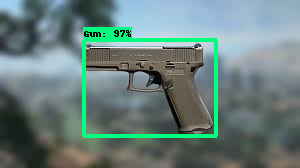

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.
    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.
    Args:
      path: the file path to the image
    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

# PROVIDE PATH TO IMAGE DIRECTORY
IMAGE_PATHS = '/content/drive/MyDrive/tensorflow_custom_object_detection/data/test_pistol.jpeg'

print('Running inference for {}... '.format(IMAGE_PATHS), end='')

image = cv2.imread(IMAGE_PATHS)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_expanded = np.expand_dims(image_rgb, axis=0)

# The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
input_tensor = tf.convert_to_tensor(image)
# The model expects a batch of images, so add an axis with `tf.newaxis`.
input_tensor = input_tensor[tf.newaxis, ...]

# input_tensor = np.expand_dims(image_np, 0)
detections = detect_fn(input_tensor)

# All outputs are batches tensors.
# Convert to numpy arrays, and take index [0] to remove the batch dimension.
# We're only interested in the first num_detections.
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
               for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

image_with_detections = image.copy()

# SET MIN_SCORE_THRESH BASED ON YOU MINIMUM THRESHOLD FOR DETECTIONS
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=0.5,
      agnostic_mode=False)

print('Done')
# DISPLAYS OUTPUT IMAGE
cv2_imshow(image_with_detections)
# CLOSES WINDOW ONCE KEY IS PRESSED